# Ipynb to 

graph and try out different 

ML concepts with a sample datasize.


A partir de las 3 tablas ya procesdas : 
* homeantennas
* sumlinks
* groundtruth

armames un datset para explorar conceptos de ML

In [183]:
## seteamos los parametros del notebook
%autosave 180
import pandas as pd; 
import numpy as np; 
import os;
import random;
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np; import os;import random;
import graphlab as gl
#esto es para dibujar directo a la notebook
gl.canvas.set_target('ipynb')

#seteamos el lugar de trabajo
HOMEDIR=os.path.expanduser('~')

PROJECTDIR = os.getcwd().split(os.sep)
PROJECTDIR =  os.sep.join(PROJECTDIR[:PROJECTDIR.index('mexico-scripts-ver2') + 1])

DATADIR = os.path.join(PROJECTDIR,'datasets')

DATADIR2 = os.path.join(PROJECTDIR,'data')
# os.chdir(DATADIR)


Autosaving every 180 seconds


In [2]:
!ls $DATADIR

data_balanced_sample.csv


In [3]:
server = 'juan' in HOMEDIR

def get_input_sframe(ds,server=server):
    if server:
        if ds == 'home_antenna': url = DATADIR +"/homeant"
        elif ds == 'sum_links': url  = DATADIR +"/sl"
        elif ds == 'gtruth_02': url  = DATADIR +"/gtruth_0215_0715" # can be near ground truth (previous to july 2015)
        elif ds == 'gtruth_01': url  =  DATADIR +"/gtruth_0114_0715" # or can be old GT
        else: print('type chosen is %s, type should be home_antenna, sum_links, gtruth_02 or gtruth_01' % ds)
    else:
        url = DATADIR.replace('mobility-study','Repositories/Tesis') + '/data_balanced_sample.csv'
    return url 

In [4]:
#from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
#NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler, SMOTE,\
#SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

## decide if load a reduced size dataset

In [5]:
# set what is the resulting sample we want of the global dataset
global_split = 0.25
global_split = None

# since we have 2 datets that will be later joined and which are going to be previously sampled, in the end this 
# independent sampling will result in that, after the join, the dataset will have a size of fraction given by 
# the `global_split` variable
if global_split:
    
    seed = 2015
    sample = np.sqrt(global_split)
    print(sample)

In [6]:
%%time

if server:
    sf_table, _ = gl.load_sframe(get_input_sframe('home_antenna',server))
    sl_table, _ = gl.load_sframe(get_input_sframe('sum_links',server))
    # no need to sample the gt table since it is very small in memory
    gt_table = gl.load_sframe(get_input_sframe('gtruth_01',server))

    if global_split:

        sf_table, _ = sf_table.random_split(sample,seed=seed)
        sl_table, _ = sl_table.random_split(sample,seed=seed)


    rename_gt = (dict([(col,col+"_gt") for col in gt_table.column_names() if col != 'USER']))

    #agrego la etiqueta "_gt" a las columnas del ground_truth
    gt_table.rename(rename_gt) 
else:
    data = pd.read_csv(get_input_sframe('sum_links',server))

CPU times: user 2.15 s, sys: 124 ms, total: 2.28 s
Wall time: 3.13 s


In [7]:
if server:
    print(sf_table.shape, sl_table.shape, gt_table.shape)
else:
    print(data.shape)

(153010, 176)


## simple format description

Aca miramos las top 10 antenas que utilizo un usuario, ordeandas de 0 a 10 segun el uso, en numero de llamados, que el user le daba a c. antenna. _0_ Seria la antenna mas utilizada y _10_ la menos utilizada. El count es la cantidad de veces que utilizo esa antenna. 

Cuando aparece _WEEKNIGHT_ en el nombre de la columna, es porque cumple la condicion de que los llamados fueron hechos de noche fuera del horario [8,20] y dentro de la semana laboral.

Siguiendo las definiciones del trabajo de Caro, un user es _EPIDEMIC_ siii su ANTENNA_WEEKNIGHT_0 (esta es la home_antenna) pertence a la zona epidemica.

El mobility_diameter es el radio de las antennas (0 si uso una sola, etc.) utilizadas por este user. Nuevamente el modificador _WEEKNIGHT_ solo aplica para antennas utilizadas en esos horarios.

In [8]:
# column names
if server:
    print(sf_table.column_names())
else:
    print(data.columns)

Index([u'USER', u'COUNT_0', u'COUNT_1', u'COUNT_2', u'COUNT_3', u'COUNT_4',
       u'COUNT_5', u'COUNT_6', u'COUNT_7', u'COUNT_8',
       ...
       u'TimeWeekDay_IN_11', u'CallsWeekEnd_IN_11', u'TimeWeekNight_IN_11',
       u'TimeWeekEnd_IN_VUL_11', u'CallsWeekDay_IN_VUL_11',
       u'CallsWeekNight_IN_VUL_11', u'TimeWeekDay_IN_VUL_11',
       u'CallsWeekEnd_IN_VUL_11', u'TimeWeekNight_IN_VUL_11',
       u'VULNERABLE_IN_11'],
      dtype='object', length=176)


## sum links description

La tabla sum_links tiene mas atributos y con data mas rica en informacion:
    
Esencialmente para c/ user miramos la cantidad de llamados y el tiempo que duraron esos llamados pero segmentando con distintos modificadores. `Time` representa la duracion del llamado y Calls el conteo de llamados.

Los modficadores/ segmentaciones son:

* mes en el cual estamos parados (12 == diciembre, ..., 08 == agosto)
* OUT/IN, separa por la direccion de los llamados si salientes u entrantes.
* _VULN_ : separa los llamados que fueron realizados hacia/desde un target_user (en una llamada hay 2 usuarios, el origin o el target) viviendo en una zona epidemica. Donde la home antena de un target_user determina su vulnerabilidad segun si es zona epidemica o no.
* Weekend, WeekDay y WeekNight son lo que suenan. Weekend el finde, Weeknight la semana pero fuera de horario laboral y Weekday en horario laboral y de lunes a viernes.

Hay solo una columna que no entra enteramente en este esquema que es VULNERABLE. Esta columna hace un conteo p/c/ usuario d cuantos target_users viven en una zona epidemica. Tambien se segmenta esta columna con los modficiadores anteriores (el mes y el out/in).

In [9]:
# column names
if server:
    print(sl_table.column_names())

# Para la
tabla gt (ground_truth) es mas simple la explicacion. Solo se busco el antenna_ID_0 (nuevamente la antenna mas utilizada) por un user

In [10]:
if server:
    print(gt_table.head())

# We need antennas metadata
to get the epidemicity of each antenna and add that info to the dataset

In [11]:
DATADIR2

'/home/teo/Repositories/Tesis/mexico-scripts-ver2/data'

In [12]:
DATADIR

'/home/teo/Repositories/Tesis/mexico-scripts-ver2/datasets'

In [13]:
#agregamos al gt su info de epidemicidad
antennas_file = DATADIR2+'/celdas_limpio.csv'

if server:
    antennas = gl.SFrame.read_csv(antennas_file, 
                              delimiter= "|", 
                usecols=['LATITUDE','LONGITUDE','CEL_ID','STATE','EPIDEMIC'],
                column_type_hints=[float, float, str,str, bool]
                            )
else:
    antennas = pd.read_csv(antennas_file,sep='|')


In [14]:
%%time
# enriquecemos la data de gt con info de epidemicidad
if server:
    # agrego tambien data de epidemicidad al simpleformat table
    sf_table = sf_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0':'CEL_ID'},
                             how = 'left')
    gt_table = gt_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0_gt':'CEL_ID'},
                             how = 'left')

    gt_table.rename({'EPIDEMIC':'EPIDEMIC_gt'});

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs


# create data matrix

In [15]:
%%time
if server:
    data = sl_table.join(gt_table['USER','EPIDEMIC_gt'], on = 'USER', how = 'inner')
    data = data.join(sf_table, on = 'USER', how = 'inner')
    #no podemos tener nulls en el target asi que dropeamos
    data = data.dropna(columns = ['EPIDEMIC_gt'], how='any')
    del sl_table, sf_table, gt_table

print(data.shape)


(153010, 176)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 142 µs


In [16]:
data['EPIDEMIC_gt'].sum(),data['EPIDEMIC'].sum()

(51709, 47344)

In [17]:
# data.query('EPIDEMIC==0  ').STATE.value_counts()

## preparamos los datasets que no pueden tomar valores negativos o categorical vars

# train test split as 
p% of set as validation and the resulting  as train

In [18]:
split_perc = 0.9
mask = np.random.rand(data.shape[0])< split_perc

val_set = data[mask==0]
data = data[mask==1]


## define our real X variable and Y vars

exclude/include features. Decide our problem (multi-target, single_target)

## in our  X features..

determine which columns have no meaning.

we are going to try different models

In [81]:
if server: iterable=data.column_names()
else: iterable=data.columns

manual_exclude_cols = [     
#      'EPIDEMIC',
      'EPIDEMIC_gt',
#       'STATE',
                ]

comprehensive_exclude_cols = [col for col in iterable if col == 'USER' 
          or ('ANTENNA' in col) ]   
                            
    
exclude_cols = manual_exclude_cols + comprehensive_exclude_cols
exclude_cols

['EPIDEMIC_gt',
 'USER',
 'ANTENNA_ID_0',
 'ANTENNA_ID_1',
 'ANTENNA_ID_2',
 'ANTENNA_ID_3',
 'ANTENNA_ID_4',
 'ANTENNA_ID_5',
 'ANTENNA_ID_6',
 'ANTENNA_ID_7',
 'ANTENNA_ID_8',
 'ANTENNA_ID_9',
 'ANTENNA_ID_WEEKNIGHT_0',
 'ANTENNA_ID_WEEKNIGHT_1',
 'ANTENNA_ID_WEEKNIGHT_2',
 'ANTENNA_ID_WEEKNIGHT_3',
 'ANTENNA_ID_WEEKNIGHT_4',
 'ANTENNA_ID_WEEKNIGHT_5',
 'ANTENNA_ID_WEEKNIGHT_6',
 'ANTENNA_ID_WEEKNIGHT_7',
 'ANTENNA_ID_WEEKNIGHT_8',
 'ANTENNA_ID_WEEKNIGHT_9']

## first our Y vars

define them with a set of different possible cases/problems to solve

In [82]:
case = 0

## people that used to live in the endemic area
if case ==0:
    case_text = "people that used to live in the endemic area"
    Y = data['EPIDEMIC_gt'] == 1
    Y_val = val_set['EPIDEMIC_gt'] == 1

## people that used to live in the endemic area *and* migrated
if case ==1:
    case_text = "people that used to live in the endemic area *and* migrated"
    Y = (data['EPIDEMIC_gt'] ==1) & (data['EPIDEMIC'] ==0)
    Y_val = (val_set['EPIDEMIC_gt'] ==1) & (val_set['EPIDEMIC'] ==0)
    
    add_exclusion_cols = ['EPIDEMIC','STATE']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

## people that migrated in any direction
if case ==2:
    case_text = "people that migrated in any direction"
    Y = data['EPIDEMIC_gt'] != data['EPIDEMIC']
    Y_val = val_set['EPIDEMIC_gt'] != data['EPIDEMIC']
    
    add_exclusion_cols = []

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

    
## people that migrated in any direction
if case ==3:
    case_text = "people that migrated in any direction"
    Y = data['EPIDEMIC_gt'] != data['EPIDEMIC']
    Y_val = val_set['EPIDEMIC_gt'] != data['EPIDEMIC']
    
    add_exclusion_cols = []

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

    
    
    
## people from the Mexico or DF states
if case == 4:
    case_text = "people from the Mexico or DF states"
    Y = (data['STATE'] == 'Distrito_Federal') | (data['STATE'] == 'Mexico')
    Y_val = (val_set['STATE'] == 'Distrito_Federal') | (val_set['STATE'] == 'Mexico')
    
    add_exclusion_cols = ['EPIDEMIC','STATE']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

In [83]:
N=5
width = 30
data.columns[(N)*width: (N+1)*width]

Index([u'TimeWeekEnd_OUT_11', u'CallsWeekDay_OUT_11', u'CallsWeekNight_OUT_11',
       u'TimeWeekDay_OUT_11', u'CallsWeekEnd_OUT_11', u'TimeWeekNight_OUT_11',
       u'TimeWeekEnd_OUT_VUL_11', u'CallsWeekDay_OUT_VUL_11',
       u'CallsWeekNight_OUT_VUL_11', u'TimeWeekDay_OUT_VUL_11',
       u'CallsWeekEnd_OUT_VUL_11', u'TimeWeekNight_OUT_VUL_11',
       u'VULNERABLE_OUT_11', u'TimeWeekEnd_IN_11', u'CallsWeekDay_IN_11',
       u'CallsWeekNight_IN_11', u'TimeWeekDay_IN_11', u'CallsWeekEnd_IN_11',
       u'TimeWeekNight_IN_11', u'TimeWeekEnd_IN_VUL_11',
       u'CallsWeekDay_IN_VUL_11', u'CallsWeekNight_IN_VUL_11',
       u'TimeWeekDay_IN_VUL_11', u'CallsWeekEnd_IN_VUL_11',
       u'TimeWeekNight_IN_VUL_11', u'VULNERABLE_IN_11'],
      dtype='object')

In [106]:
%%time

if server: iterable=data.column_names()
else: iterable=data.columns


X = data[[col for col in iterable if col not in exclude_cols]]

X_val = val_set[[col for col in iterable if col not in exclude_cols]]

if server: iterable=X.column_names()
else: iterable=X.columns
    
# clean negative/Null vals in count cols 
for col in [col for col in iterable if 'COUNT' in col]:
    X[col]= X[col].apply(lambda x :  x if x>=0 else 0)
    X_val[col]= X_val[col].apply(lambda x :  x if x>=0 else 0)



/home/teo/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/teo/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CPU times: user 2.2 s, sys: 20 ms, total: 2.22 s
Wall time: 2.2 s


In [107]:
X.target

AttributeError: 'DataFrame' object has no attribute 'target'

In [108]:
corr = pd.DataFrame(X).copy()
corr['target'] = Y
corr = corr.corr()

In [109]:
corr.shape

(154, 154)

In [110]:
corr.query('target>0.3')

,COUNT_0,COUNT_1,COUNT_2,COUNT_3,COUNT_4,COUNT_5,COUNT_6,COUNT_7,COUNT_8,COUNT_9,...,CallsWeekEnd_IN_11,TimeWeekNight_IN_11,TimeWeekEnd_IN_VUL_11,CallsWeekDay_IN_VUL_11,CallsWeekNight_IN_VUL_11,TimeWeekDay_IN_VUL_11,CallsWeekEnd_IN_VUL_11,TimeWeekNight_IN_VUL_11,VULNERABLE_IN_11,target
EPIDEMIC,0.009705,0.006327,0.000414,-0.001744,-0.004846,-0.010385,-0.011603,-0.013314,-0.015926,-0.017155,...,-0.192393,-0.076484,0.176801,0.295220,0.218589,0.216921,0.293875,0.101647,0.517824,0.440485
VULNERABLE_OUT_12,0.128052,0.147623,0.153419,0.156673,0.155605,0.153596,0.152774,0.151155,0.149325,0.148534,...,-0.098973,-0.040251,0.296239,0.403785,0.331718,0.340993,0.410982,0.201230,0.770884,0.502270
VULNERABLE_IN_12,0.124254,0.144302,0.151880,0.154133,0.152823,0.150853,0.149644,0.147964,0.146500,0.145218,...,-0.098398,-0.040161,0.299880,0.406905,0.335452,0.344090,0.414495,0.204302,0.780608,0.500177
CallsWeekEnd_OUT_VUL_08,0.241849,0.255043,0.241735,0.241338,0.233076,0.228017,0.226054,0.223165,0.219128,0.215142,...,-0.064692,-0.031681,0.440879,0.552738,0.501368,0.441317,0.622223,0.290928,0.388549,0.305785
VULNERABLE_OUT_08,0.103318,0.119970,0.127796,0.133238,0.131833,0.129857,0.128899,0.127450,0.126544,0.125857,...,-0.127057,-0.056088,0.262425,0.363155,0.295926,0.302575,0.368529,0.175501,0.696991,0.553999
CallsWeekEnd_IN_VUL_08,0.245582,0.247216,0.232994,0.229469,0.220568,0.213658,0.209337,0.204932,0.199916,0.196579,...,-0.053442,-0.028741,0.494040,0.615443,0.560631,0.483309,0.707038,0.323002,0.397773,0.312873
VULNERABLE_IN_08,0.098343,0.116136,0.123542,0.127699,0.126191,0.124452,0.123460,0.122097,0.121048,0.120465,...,-0.128234,-0.055823,0.264147,0.363787,0.297439,0.304318,0.368949,0.178842,0.703746,0.556184
VULNERABLE_OUT_09,0.124086,0.141227,0.148377,0.154294,0.153158,0.151573,0.150392,0.149079,0.148365,0.147816,...,-0.117928,-0.052952,0.276482,0.381801,0.310399,0.320518,0.385483,0.185983,0.732942,0.536126
VULNERABLE_IN_09,0.116399,0.136280,0.144160,0.149038,0.147009,0.144716,0.143467,0.141819,0.141149,0.140551,...,-0.118033,-0.052777,0.277393,0.382360,0.312522,0.321081,0.386575,0.188703,0.740587,0.538719
VULNERABLE_OUT_10,0.136734,0.155251,0.162145,0.166793,0.165415,0.162609,0.161581,0.160086,0.159080,0.158180,...,-0.105432,-0.044597,0.295682,0.404095,0.331209,0.341563,0.408745,0.200842,0.785427,0.520381


In [111]:
X.shape, Y.shape

((137759, 154), (137759,))

## dummy-ize categorical cols

In [113]:
if server: iterable=X.column_names()
else: iterable=X.columns


In [114]:
categorical_cols = [
    'STATE'
]

In [115]:
for col in categorical_cols:
    if col not in exclude_cols:
        X[col] = X[col].astype('category')
    #     if X[col].dtype != 'category':
    #         continue 
        X = pd.concat([X,pd.get_dummies(X[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(np.int8)],\
                  axis=1 ,join = 'inner')
        X.drop(col, axis =1 , inplace=True)

        # now onto test_table
        X_val[col] = X_val[col].astype('category')
        X_val = pd.concat([X_val,pd.get_dummies(X_val[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(np.int8)],\
                  axis=1 ,join = 'inner')

        X_val.drop(col, axis =1 , inplace=True)


/home/teo/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/teo/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [116]:
a=data['EPIDEMIC_gt'].sum();b= data.shape[0]
a*1.0/b

0.33803236086208521

In [117]:
a=val_set['EPIDEMIC'].sum();b= val_set.shape[0]
a*1.0/b

0.31256966756278276

# cast to numpy types

In [118]:
# %%time
# X = X.to_dataframe()
# Y = pd.Series(data=Y.to_numpy(),dtype=np.bool,name = 'EPIDEMIC_gt')
# X_val = X_val.to_dataframe()
# Y_val = pd.Series(data=Y_val.to_numpy(),dtype=np.bool,name = 'EPIDEMIC_gt')

# Instance fast model with MNB
#### convertimos la data en numpy, previamente limpiando las columnas de antennas ya que el clasificador no acepta strings

In [119]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import *
from sklearn.metrics import *
# from sklearn.cross_validation import *
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     train_test_split, KFold, cross_val_predict, 
                                     cross_val_score, learning_curve, validation_curve
                                    )

## remember the Multinomail NB assumes no negative values
are present in the dataset as this must be `count` data

In [120]:
%%time
start_time = time.time()
param_grid = {'alpha':[1e-3, 1e-1, 1e1,1e0], 'fit_prior': [True,False],
             }

mnb  = MultinomialNB( )

clf = GridSearchCV(mnb, param_grid, scoring='f1_weighted', fit_params=None, n_jobs=-1, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf2 = MultinomialNB( )
#how many parameters to randomly search for
#n_iter_search = 45

#random_search = RandomizedSearchCV(rforest, param_distributions=param_grid,
                                 #  n_iter=n_iter_search, n_jobs =8, verbose=3)

elapsed_time =  time.time() - start_time

#Y = categorical(train_table_target.values, drop=True).astype(int)

clf.fit(X,Y)

elapsed_time =   time.time() - start_time 

print('Grid Search took %s seconds to run' % (elapsed_time))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1


#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('\n Best estimator was %s \n' % str(clf.best_estimator_))
print('\n Best estimator was %s \n' % str(clf.best_score_))

clf2.set_params(**clf.best_params_)

clf2.fit(X,Y)


#converted_dict = evaluation_print(clf, X_val, test_table_target.values, test_table.index.values, 
#                              test_table_target[test_table_target>0].index.values,start_date,future)

print(classification_report(Y_val,clf2.predict(X_val)))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.001, fit_prior=True .....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.783193, total=   0.2s
[CV] alpha=0.001, fit_prior=True .....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.957997, total=   0.2s
[CV] alpha=0.001, fit_prior=True .....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.746341, total=   0.2s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.783093, total=   0.2s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.957997, total=   0.2s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.746322, total=   0.2s
[CV] ........ alp

[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    5.5s remaining:    1.8s


[CV] ........ alpha=1.0, fit_prior=True, score=0.783193, total=   0.2s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........ alpha=1.0, fit_prior=True, score=0.957997, total=   0.2s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........ alpha=1.0, fit_prior=True, score=0.746341, total=   0.2s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....... alpha=1.0, fit_prior=False, score=0.783093, total=   0.2s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....... alpha=1.0, fit_prior=False, score=0.957997, total=   0.2s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....... alpha=1.0, fit_prior=False, score=0.746322, total=   0.2s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.1s finished
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/teo/venv

Grid Search took 7.41091299057 seconds to run

 Best estimator was MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True) 


 Best estimator was 0.829176263981 

             precision    recall  f1-score   support

      False       0.88      0.88      0.88     10109
       True       0.76      0.76      0.76      5142

avg / total       0.84      0.84      0.84     15251

CPU times: user 7.09 s, sys: 208 ms, total: 7.3 s
Wall time: 7.56 s


In [121]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.82235050820425315

In [122]:
Y.shape, Y.sum()

((137759,), 46567)

In [123]:
Y_val.sum()*1.0/Y_val.size

0.33715821913317162

In [125]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.82235050820425315

In [126]:
coln = 2
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

fit_prior
False    0.829137
True     0.829176
Name: mean_score, dtype: float64
fit_prior
False    0.0
True     0.0
Name: mean_score, dtype: float64


## now graphlab models 

In [127]:
from sklearn.ensemble import RandomForestClassifier
from graphlab import random_forest_classifier, boosted_trees_classifier, logistic_classifier
from graphlab.toolkits import cross_validation, model_parameter_search

# get kfolds

In [128]:
%%time
num_folds = 10

if server:   
    kfold = cross_validation.KFold(
    X,num_folds=num_folds)
else:
    kfold = cross_validation.KFold(
    gl.SFrame(X),num_folds=num_folds)

CPU times: user 2.98 s, sys: 72 ms, total: 3.06 s
Wall time: 2.55 s


In [129]:
%%time
num_folds = 10

if server:   
    X['target'] = Y
    X_val['target'] = Y_val
    kfold = cross_validation.KFold(
    X,num_folds=num_folds)
else:
    X_gl= gl.SFrame(X)
    Y_gl = gl.SArray(Y)
    X_val_gl= gl.SFrame(X_val)
    Y_val_gl = gl.SArray(Y_val)
    X_gl['target'] = Y_gl
    X_val_gl['target'] = Y_val_gl
    
    kfold = cross_validation.KFold(
    X_gl,num_folds=num_folds)

CPU times: user 3.4 s, sys: 124 ms, total: 3.52 s
Wall time: 2.53 s


## RandomForest 
HyperParams Grid Search

In [130]:

param_grid = {
    "target":"target",
    
    'metric': [
                'auc',
                'log_loss',
                 ], 
    
    'max_iterations': [
                    50,
                    100,
                    150,
                    200,
                    ],
    
  'column_subsample': [
                  np.sqrt(X_gl.shape[1])/X_gl.shape[1],
                  np.log2(X_gl.shape[1])/X_gl.shape[1],
                  0.5,
                  0.1,
                  ], 
#     "bootstrap": [ 
#                 False,
#                 True,
#                     ],
#     "min_child_weight": np.append(np.random.randint(3,15,3),[3]),
    'max_depth':[
                 3,
                 6,
                 9,
                 12,
                ], 
   "class_weights": [
#                    'balanced',
                   None,
                   ],
#     "validation_set": X_val_gl,
              }

model_factory = random_forest_classifier.create

In [131]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
                                            model_parameters = param_grid, 
                                             perform_trial_run = True,
                                            )

search_results = model_search.get_results()

all_time = start_time - time.time()

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-21-2017-20-55-4500000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-21-2017-20-55-4500000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-21-2017-20-55-4500000' already exists. Renaming the job to 'Model-Parameter-Search-May-21-2017-20-55-4500000-7cd59'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-21-2017-20-55-4500000-7cd59' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-21-2017-20-55-4500000-7cd59' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-21-2017-20-55-4500001' ready for execution


CPU times: user 20 s, sys: 2.3 s, total: 22.4 s
Wall time: 33min 50s


In [132]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-21 20:56:10,20.0501670837,None,None,None
_train_test_model-0-1,Completed,2017-05-21 20:56:30,19.4214670658,None,None,None
_train_test_model-0-2,Completed,2017-05-21 20:56:50,19.6539859772,None,None,None
_train_test_model-0-3,Completed,2017-05-21 20:57:10,21.7544441223,None,None,None
_train_test_model-0-4,Completed,2017-05-21 20:57:32,21.0537321568,None,None,None
_train_test_model-0-5,Completed,2017-05-21 20:57:53,20.357640028,None,None,None
_train_test_model-0-6,Completed,2017-05-21 20:58:13,20.4278039932,None,None,None
_train_test_model-0-7,Completed,2017-05-21 20:58:34,20.6778879166,None,None,None
_train_test_model-0-8,Completed,2017-05-21 20:58:54,21.1203668118,None,None,None
_train_test_model-0-9,Completed,2017-05-21 20:59:15,21.2018609047,None,None,None


In [135]:
search_results.shape

(10, 14)

In [134]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0132921460417 | 0.846037807957 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+-------------------+----------------+
| column_subsample |        std        |      mean      |
+------------------+-------------------+----------------+
| 0.0733235575107  |  0.0107811400256  | 0.846075595402 |
| 0.0405331118877  |  0.0061313743628  | 0.836219413582 |
|       0.5        | 0.000553704494549 | 0.865599021817 |
+------------------+-------------------+----------------+
[3 rows x 3 columns]

+-----------+------------------+----------------+
| max_depth |       std        |      mean      |
+-----------+------------------+----------------+
|     12    | 0.0115676799752  | 0.855283503218 |
|     3     | 0.0029334643918  | 0.830117977629 |
|     9     | 0.00621415310707 | 0.

### Refit best model for feature importance

In [136]:
params = model_search.get_best_params()

In [137]:
params

{'class_weights': None,
 'column_subsample': 0.5,
 'max_depth': 12,
 'max_iterations': 150,
 'metric': 'auc',
 'min_child_weight': 8,
 'min_loss_reduction': 10,
 'row_subsample': 0.9,
 'target': 'target'}

In [145]:
%%time
best_model =  random_forest_classifier.create(dataset=X_gl,
                                             validation_set = X_val_gl,
                                             **params)

Random forest classifier:

--------------------------------------------------------

Number of examples          : 137759

Number of classes           : 2

Number of feature columns   : 185

Number of unpacked features : 185

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.642450     | 0.903585     | 0.899083       |

| 2         | 1.235604     | 0.909997     | 0.904973       |

| 3         | 1.984149     | 0.910507     | 0.905782       |

| 4         | 2.689806     | 0.912457     | 0.907216       |

| 5         | 3.281475     | 0.912436     | 0.906998       |

| 6         | 3.931058     | 0.912367     | 0.907049       |

| 10        | 6.979820     | 0.912911     | 0.907799       |

| 11        | 7.643256     | 0.912636     | 0.907483       |

| 15        | 10.441819    | 0.912118     | 0.906804       |

| 20        | 13.463150    | 0.912832     | 0.907502       |

| 25        | 16.840414    | 0.913692     | 0.908540       |

| 30        | 20.540227    | 0.913566     | 0.908385       |

| 35        | 24.007857    | 0.914284     | 0.909261       |

| 40        | 27.144311    | 0.914136     | 0.909091       |

| 45        | 30.028066    | 0.914321     | 0.909197       |

| 50        | 33.346990    | 0.914745     | 0.909587       |

| 51        | 34.026611    | 0.914817     | 0.909672       |

| 55        | 36.653860    | 0.914789     | 0.909602       |

| 60        | 39.861430    | 0.914815     | 0.909651       |

| 65        | 42.733484    | 0.914961     | 0.909761       |

| 70        | 45.650422    | 0.915061     | 0.909945       |

| 75        | 48.531659    | 0.915309     | 0.910231       |

| 80        | 52.133444    | 0.915445     | 0.910378       |

| 85        | 55.687027    | 0.915177     | 0.910062       |

| 90        | 59.053129    | 0.915123     | 0.910064       |

| 95        | 62.232842    | 0.915088     | 0.910124       |

| 100       | 65.603207    | 0.915302     | 0.910317       |

| 101       | 66.265940    | 0.915349     | 0.910395       |

| 105       | 68.851849    | 0.915313     | 0.910356       |

| 110       | 71.846869    | 0.915274     | 0.910349       |

| 115       | 75.220603    | 0.915152     | 0.910217       |

| 120       | 78.135149    | 0.915104     | 0.910195       |

| 125       | 81.494676    | 0.915089     | 0.910173       |

| 130       | 84.542677    | 0.915052     | 0.910134       |

| 135       | 88.241168    | 0.915088     | 0.910194       |

| 140       | 91.633799    | 0.915197     | 0.910302       |

| 145       | 94.979358    | 0.915209     | 0.910330       |

| 150       | 98.231700    | 0.915175     | 0.910297       |

+-----------+--------------+--------------+----------------+

CPU times: user 4min 19s, sys: 2.37 s, total: 4min 22s
Wall time: 1min 41s


In [147]:
best_feat = best_model.get_feature_importance()
best_feat.head(20)

name,index,count
EPIDEMIC,None,2393
MOBILITY_DIAMETER,None,2266
COUNT_0,None,2257
MOBILITY_DIAMETER_WEEKNIGHT ...,None,1811
COUNT_WEEKNIGHT_0,None,722
TimeWeekDay_OUT_10,None,563
TimeWeekDay_OUT_12,None,555
CallsWeekDay_OUT_12,None,527
TimeWeekDay_IN_09,None,517
TimeWeekDay_OUT_09,None,500


In [148]:
best_model.training_time

98.232268

In [149]:
test_error = best_model.evaluate(X_val_gl)

test_error

{'accuracy': 0.8554848862369681,
 'auc': 0.9102974870681293,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  1014 |
 |      0       |        0        |  9095 |
 |      1       |        1        |  3952 |
 |      1       |        0        |  1190 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7819548872180452,
 'log_loss': 0.3843577405344554,
 'precision': 0.7958115183246073,
 'recall': 0.7685725398677558,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+-------+
 | threshold | fpr | tpr |  p   |   n   |
 +-----------+-----+-----+------+-------+
 |    0.0    | 1.0 | 1.0 | 5142 | 10109 |
 |   1e-05   | 1.0 | 1.0 | 5142 | 10109 |
 |   2e-05   |

In [160]:
best_model.get_current_options#()

<bound method RandomForestClassifier.get_current_options of Class                          : RandomForestClassifier

Schema
------
Number of examples             : 137759
Number of feature columns      : 185
Number of unpacked features    : 185
Number of classes              : 2

Settings
--------
Number of trees                : 150
Max tree depth                 : 12
Training time (sec)            : 98.2323
Training auc                   : 0.9152
Validation auc                 : 0.9103
>

# Boosted Classifier
### HyperParams search

In [111]:
# Boosted Trees HyperParams

target_col = 'EPIDEMIC_gt'
# target_col = 'Y'

params = {
    'target': target_col, ## the target column string name 
    'max_iterations': [
                      200,
                       250,
#                        90,
                       120
                      ], #The maximum number of iterations for boosting. Each iteration == extra tree.
    'class_weights': [
                      None, 
#                       'auto',
    ], #Weights the examples in the training data according to the given class weights.
#     'class_weights': [None],
    'max_depth': [
        2,
#         3,
        4,
        6,
        9,
    ], #Maximum depth of a tree. Must be at least 1.
    'step_size': [
        1e-1,
        0.5,
#         1e-2,
        1,
    ], # Step size (shrinkage) used in update to prevents overfitting
    'min_loss_reduction': [
        1e-2,
        1,
        10,
    ], #Minimum loss reduction required to make a further partition/split a node during the tree learning
    'min_child_weight': [
#         1e-2,
        2,
#         5,
        10,
    ], # Controls the minimum weight of each leaf node . larger values > less overfitting
#     'row_subsample': [
#         0.5,
#         0.75,
#     ], #Subsample the ratio of the training set in each iteration of tree construction
    'column_subsample': [
#         0.01,
        0.1,
        0.05,
                        ], # Subsample the ratio of the columns in each iteration of tree construction
    #'metric': ['accuracy', 'auc', 'f1_score','recall','precision'], # Performance metric(s) that are tracked during training     
    'metric': ['auc'],
    'random_seed' : int(abs(hash('im not joking...'))%1e6) 
}

model_factory = boosted_trees_classifier.create

### Grid Search Boosted 

In [112]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
            model_parameters = params, perform_trial_run = True  )

search_results = model_search.get_results()

all_time = start_time - time.time()

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-20-2017-17-41-5100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-20-2017-17-41-5100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-20-2017-17-41-5100000' already exists. Renaming the job to 'Model-Parameter-Search-May-20-2017-17-41-5100000-122e5'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-20-2017-17-41-5100000-122e5' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-20-2017-17-41-5100000-122e5' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-20-2017-17-41-5100001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-20-2017-17-41

CPU times: user 6.79 s, sys: 1.3 s, total: 8.1 s
Wall time: 31min 58s


In [113]:
res = model_search.get_metrics()
res

In [114]:
# res['exception_message']

In [115]:
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-20 17:42:38,8.6289100647,None,None,None
_train_test_model-0-1,Completed,2017-05-20 17:42:46,7.70163702965,None,None,None
_train_test_model-0-2,Completed,2017-05-20 17:42:54,7.11124587059,None,None,None
_train_test_model-0-3,Completed,2017-05-20 17:43:01,7.00011920929,None,None,None
_train_test_model-0-4,Completed,2017-05-20 17:43:08,5.86911201477,None,None,None
_train_test_model-0-5,Completed,2017-05-20 17:43:14,22.3444530964,None,None,None
_train_test_model-0-6,Completed,2017-05-20 17:43:36,5.64018297195,None,None,None
_train_test_model-0-7,Completed,2017-05-20 17:43:42,5.45726013184,None,None,None
_train_test_model-0-8,Completed,2017-05-20 17:43:48,6.27430105209,None,None,None
_train_test_model-0-9,Completed,2017-05-20 17:43:54,7.23296689987,None,None,None


In [116]:
search_results.shape

(10, 17)

In [117]:
search_results.head()

class_weights,column_subsample,early_stopping_rounds,max_depth,max_iterations,metric,min_child_weight
None,0.1,5,6,250,auc,10
None,0.05,5,4,250,auc,2
None,0.05,5,9,120,auc,2
None,0.1,5,4,250,auc,2
None,0.1,5,9,120,auc,2
None,0.05,5,4,120,auc,2
None,0.1,5,9,250,auc,10
None,0.05,5,6,120,auc,10
None,0.05,5,9,120,auc,10
None,0.1,5,2,250,auc,10


In [118]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0120394106195 | 0.859469346438 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+-----------------+----------------+
| column_subsample |       std       |      mean      |
+------------------+-----------------+----------------+
|       0.05       | 0.0106796352324 | 0.857533698718 |
|       0.1        |  0.012974850413 | 0.861404994159 |
+------------------+-----------------+----------------+
[2 rows x 3 columns]

+-----------------------+-----------------+----------------+
| early_stopping_rounds |       std       |      mean      |
+-----------------------+-----------------+----------------+
|           5           | 0.0120394106195 | 0.859469346438 |
+-----------------------+-----------------+----------------+
[1 rows x 3 columns]

+-----------+---------------

## hyperparameter results

* class_weights: None, gana por afano
* column_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor
* row_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor, refinar
* max_depth: varia mucho, refinar
* max_iterations: tampoco queda claro si poquito o mucho es mejor, reprobar
* metric: el f1_score es el unico que no parece variar mucho,los demas cambian demasiado
* min_child_weight: varia mucho, reprobar con mas
* min_loss_reduction: varia mucho, reprobar
* step_size: mas grande parece ser mejor> 0.1

### Results

* bootstrap  ???= False es 5% mejor
* min_samples_leaf ????= mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators ???= mas pareceria mejor, pero depende del app y hay que ver 'cuanto' mejora por app
* citerion ???= entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features ???= no afecta al score. con auto esta bien
* max_depth ??=  mas es mejor. intentaria probar con >15

# Sklearn 

validation, bias variance, learning curves  and decision tree models

In [162]:
from sklearn.linear_model import *
from sklearn.ensemble import *

from sklearn import model_selection

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import *

from sklearn.preprocessing import label_binarize, scale, StandardScaler

from sklearn.metrics import *

from sklearn.tree import *

from sklearn.grid_search import *

from sklearn.pipeline import Pipeline

## bias variance trade-off in the number of attributes
we first used a random forest to get the best attributes in the model and now will try to overfit the validation set using too many features.

In [170]:
best_columns = best_feat['name'].to_numpy()

X[best_columns].columns

Index([u'EPIDEMIC', u'MOBILITY_DIAMETER', u'COUNT_0',
       u'MOBILITY_DIAMETER_WEEKNIGHT', u'COUNT_WEEKNIGHT_0',
       u'TimeWeekDay_OUT_10', u'TimeWeekDay_OUT_12', u'CallsWeekDay_OUT_12',
       u'TimeWeekDay_IN_09', u'TimeWeekDay_OUT_09',
       ...
       u'STATE_Quintana_Roo', u'STATE_San_Luis_Potosi', u'STATE_Sinaloa',
       u'STATE_Sonora', u'STATE_Campeche', u'STATE_Baja_California_Sur',
       u'STATE_Baja_California', u'STATE_Aguascalientes', u'STATE_Yucatan',
       u'STATE_Zacatecas'],
      dtype='object', length=185)

In [171]:
from sklearn.model_selection import validation_curve

In [173]:
from sklearn.linear_model import LogisticRegression

In [177]:
inv_c_range = np.logspace(-3, 3, 30)
c_range = 1./inv_c_range
c_range

array([  1.00000000e+03,   6.21016942e+02,   3.85662042e+02,
         2.39502662e+02,   1.48735211e+02,   9.23670857e+01,
         5.73615251e+01,   3.56224789e+01,   2.21221629e+01,
         1.37382380e+01,   8.53167852e+00,   5.29831691e+00,
         3.29034456e+00,   2.04335972e+00,   1.26896100e+00,
         7.88046282e-01,   4.89390092e-01,   3.03919538e-01,
         1.88739182e-01,   1.17210230e-01,   7.27895384e-02,
         4.52035366e-02,   2.80721620e-02,   1.74332882e-02,
         1.08263673e-02,   6.72335754e-03,   4.17531894e-03,
         2.59294380e-03,   1.61026203e-03,   1.00000000e-03])

In [178]:
%%time
train_scores, test_scores = validation_curve(
    LogisticRegression(), X, Y, param_name="C", param_range=c_range,
    cv=10, scoring="neg_log_loss", n_jobs=-1)

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/teo/venv2.7/local/lib/python2.7/site-packages/sklearn/metrics/scorer.p

CPU times: user 2min 4s, sys: 33 s, total: 2min 37s
Wall time: 4h 31min 3s


In [179]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [186]:
test_scores_mean

array([-0.49085952, -0.48891622, -0.48920325, -0.49195079, -0.49012646,
       -0.48779029, -0.48944502, -0.48706873, -0.49302163, -0.48872269,
       -0.48951711, -0.49265123, -0.48905389, -0.48966411, -0.48742003,
       -0.49341477, -0.49087981, -0.49176846, -0.49064776, -0.48529751,
       -0.48893539, -0.48714409, -0.48850236, -0.4892446 , -0.48859467,
       -0.49047194, -0.48922167, -0.48957505, -0.48774497, -0.48825311])

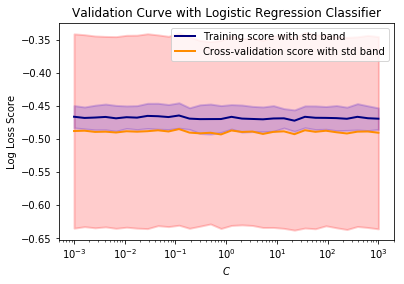

In [188]:
plt.title("Validation Curve with Logistic Regression Classifier")
plt.xlabel("$C$")
plt.ylabel("Log Loss Score")
# plt.ylim(0.0, 10.1)

lw = 2

plt.semilogx(c_range, train_scores_mean, label="Training score with std band",
             color="navy", lw=lw)

plt.fill_between(c_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="blue", lw=lw)

plt.semilogx(c_range, test_scores_mean, label="Cross-validation score with std band",
             color="darkorange", lw=lw)

plt.fill_between(c_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)

plt.legend(loc="best")


## Logistic Regression cross validation

In [54]:

clf =  LogisticRegressionCV(n_jobs =3, class_weight= 'balanced', scoring = 'f1',cv=3)

clf.fit(X_train,y_train)


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['class'] = clf.predict(X_test)
predicted_proba[gt] =  y_test
predicted_proba.sort_values(by = 'prob',ascending = False, inplace = True)

cut_percentages = [10,20,30,40]
#converted = (predicted_proba['class']==1)
#me fijo todos los users que van a convertir en el futuro


start = 0
mobility_dict = {}
index_segments = []
for i in cut_percentages:
    cut_size = int(len(predicted_proba)*i/100.0)    
    bool_array = (~np.ones(len(predicted_proba), dtype=bool))
    bool_array[start: start + cut_size] = True
    index_segments += [bool_array]
    start = start + cut_size
#    subtable = 
    #mobility_dict[str(i)] = predicted_proba.loc[index_segments[-1],'ref_hash']
    
    print(classification_report(predicted_proba.loc[index_segments[-1],gt].values,
                            predicted_proba.loc[index_segments[-1],'class'].values ))
    
    
print(classification_report(predicted_proba.loc[:,gt].values,
                            predicted_proba.loc[:,'class'].values ))
    
    
cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

all_time =   time.time() - start_time

#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('This cell took %s seconds to run' % all_time)


             precision    recall  f1-score   support

          0       0.67      0.85      0.75     43545
          1       0.40      0.19      0.25     22464

avg / total       0.58      0.63      0.58     66009

             precision    recall  f1-score   support

          0       0.64      0.75      0.69     83353
          1       0.40      0.28      0.33     48666

avg / total       0.55      0.58      0.56    132019

             precision    recall  f1-score   support

          0       0.63      0.67      0.65    124185
          1       0.39      0.35      0.37     73843

avg / total       0.54      0.55      0.55    198028

             precision    recall  f1-score   support

          0       0.62      0.56      0.59    164393
          1       0.38      0.44      0.41     99645

avg / total       0.53      0.52      0.52    264038

             precision    recall  f1-score   support

          0       0.64      0.66      0.65    415477
          1       0.39      0.36 

AttributeError: 'LogisticRegressionCV' object has no attribute 'grid_scores_'

# REST of shit

### Count Featurizer on Antennas
nos quedamos con las columnas de antennas y en graphlab aplicamos el algo de CountFeaturizer para cada categoria de
Antenna_ID_N


In [ ]:
%%time
import graphlab as gl
from graphlab.toolkits.feature_engineering import *
ant_cols = [col for col in X_train.columns if "ANTENNA_ID" in col]
ant_sframe_fit = gl.SFrame(X_fit[ant_cols + ['y']])
ant_sframe_train = gl.SFrame(X_train[ant_cols + ['y']])
ant_sframe_val = gl.SFrame(X_val[ant_cols + ['y']])

In [ ]:
%%time
countfeat = gl.feature_engineering.create(ant_sframe_fit, 
               CountFeaturizer(target='y'))

# Transform the train set. This is the dataset I will train my classifier on
transformed_ant_train = countfeat.transform(ant_sframe_train)
transformed_ant_val = countfeat.transform(ant_sframe_val)

del ant_sframe_fit,ant_sframe_train,ant_sframe_val

#por alguna razon guarda los valores de probabilidad como una lista de un unico valor
for col in [col for col in transformed_ant_train.column_names() if "prob_" in col]:
    transformed_ant_train[col] = transformed_ant_train[col].apply(lambda x: x[0]) 
    transformed_ant_val[col] = transformed_ant_val[col].apply(lambda x: x[0]) 

#me quedo solo con los valores de probabilidad.
transformed_ant_train = transformed_ant_train[[col for col in transformed_ant_train.column_names() if "prob_" in col]]
transformed_ant_val = transformed_ant_val[[col for col in transformed_ant_train.column_names() if "prob_" in col]]

transformed_ant_val = transformed_ant_val.to_dataframe()
transformed_ant_train = transformed_ant_train.to_dataframe()

In [ ]:
X_val[ant_cols] = transformed_ant_val.values
X_train[ant_cols] = transformed_ant_train.values
del transformed_ant_train, transformed_ant_val

### Cross Validate SGD

In [ ]:
param_grid = [
  { 'alpha': [1e-3,5*1e-3,1e-2], 'l1_ratio': [3*1e-2,1e-3,6*1e-4], 'n_iter': [2,3]
  }
    ]

In [37]:
start_time = time.time()

param_grid = [
  { 'alpha': [1e-3,5*1e-3,1e-2], 'l1_ratio': [3*1e-2,1e-3,6*1e-4], 'n_iter': [2,3]
  }
    ]
sgd = SGDClassifier(loss='modified_huber', penalty='elasticnet', 
             fit_intercept=True,  shuffle=True, 
                    n_jobs=3,learning_rate='optimal', power_t =2, eta0 =5,
                    class_weight='balanced', average=40)

clf =GridSearchCV(sgd, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)



predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['class'] = clf.predict(X_test)
predicted_proba[gt] =  y_test
predicted_proba.sort_values(by = 'prob',ascending = False, inplace = True)

cut_percentages = [10,20,30,40]
#converted = (predicted_proba['class']==1)
#me fijo todos los users que van a convertir en el futuro


start = 0
mobility_dict = {}
index_segments = []
for i in cut_percentages:
    cut_size = int(len(predicted_proba)*i/100.0)    
    bool_array = (~np.ones(len(predicted_proba), dtype=bool))
    bool_array[start: start + cut_size] = True
    index_segments += [bool_array]
    start = start + cut_size
#    subtable = 
    #mobility_dict[str(i)] = predicted_proba.loc[index_segments[-1],'ref_hash']
    
    print(classification_report(predicted_proba.loc[index_segments[-1],gt].values,
                            predicted_proba.loc[index_segments[-1],'class'].values ))
    
    
print(classification_report(predicted_proba.loc[:,gt].values,
                            predicted_proba.loc[:,'class'].values ))
    
    
cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

all_time =   time.time() - start_time

#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('This cell took %s seconds to run' % all_time)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.125354 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.127442 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.119463 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.132910 -   3.1s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.133858 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.125862 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.114065 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.125576 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.125882 -   2.8s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.138072 -   3.3s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.133482 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.133945 -   3.2s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.124318 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.125224 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.129423 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.131845 -   3.1s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.135827 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.128485 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.125477 -   2.4s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.125957 -   2.8s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.127511 -   2.6s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.127618 -   2.8s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.125386 -   2.8s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.136983 -   3.0s


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   47.9s


[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.120290 -   2.5s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.118753 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.127159 -   2.9s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.127485 -   3.3s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.139728 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.130469 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.129161 -   2.5s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.130159 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.127613 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.132956 -   3.1s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.143005 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.135926 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.128098 -   2.4s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.127078 -   2.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.126921 -   2.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.138152 -   3.6s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.106208 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.143076 -   2.8s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.132427 -   2.5s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.125901 -   2.9s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.128001 -   2.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.135568 -   3.1s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.132579 -   4.4s
[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.136589 -   3.7s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.124134 -   2.8s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.130883 -   2.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.122741 -   3.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.132433 -   3.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............
[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.135111 -   3.4s
[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.135908 -   3.1s


[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.7min finished


             precision    recall  f1-score   support

          0       1.00      0.31      0.47    355992
          1       0.06      0.99      0.11     15152

avg / total       0.96      0.33      0.45    371144

This cell took 108.56432461738586 seconds to run


In [ ]:
threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))

In [38]:
clf.best_estimator_

SGDClassifier(alpha=0.005, average=40, class_weight='balanced', epsilon=0.1,
       eta0=5, fit_intercept=True, l1_ratio=0.0006000000000000001,
       learning_rate='optimal', loss='modified_huber', n_iter=3, n_jobs=3,
       penalty='elasticnet', power_t=2, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [39]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

n_iter
2.0    0.125741
3.0    0.132943
Name: mean_score, dtype: float64
n_iter
2.0    0.002609
3.0    0.002703
Name: mean_score, dtype: float64


### Results
* l1_ratio = cuanto mas chico mejor con lo cual la perdida l2 parece ser mejor
* alpha = 1e-3 es suficiente pues casi no afecta el score
* power_t = muy variado, no parece haber correlacion entre el tamanyo y el avg, mean_score
* eta0 = no afecta mucho pero parece ser que con ser >1 ya esta
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

In [51]:
len(predicted_proba)

371161

## Cross Validate NN

In [35]:
start_time = time.time()

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

param_grid = { 'alpha': [1e-1,5*1e-2,1e-2],
              'hidden_layer_sizes':[(50,),(15,5)],
              'learning_rate': ['adaptive',"invscaling"],
              "algorithm": ['adam'],'momentum': [1e-2, 1e-1, 0.5],
  'power_t': [1e-3, 5*1e-4, 1e-5], 'activation':['logistic','relu']
 }

mlp = MLPClassifier(shuffle=True, 
                 verbose=True)

clf =GridSearchCV(mlp, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 
Iteration 1, loss = 0.20405210
Iteration 1, loss = 0.20380843
Iteration 1, loss = 0.20378706
Iteration 1, loss = 0.20405210


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.5s
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.7s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   2.1s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.9s


KeyboardInterrupt: 

In [1]:
clf.best_estimator_

NameError: name 'clf' is not defined

In [52]:
# compare best parameters to tune
coln=1
cv_result.groupby(cv_result.columns[coln])['mean_score'].mean()
cv_result.groupby(cv_result.columns[coln])['mean_score'].std()

alpha
0.00     0.000007
0.01     0.000007
0.10     0.000007
0.50     0.000007
1.00     0.000007
10.00    0.000007
Name: mean_score, dtype: float64

### Results
* activation = logistic es 10% mejor
* alpha = 1e-2 el mejor 
* power_t = cuanto mas chico mejor, 1e-3 por lo menos
* hidden_layer_size = menos layers es mejor..?
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

## Bernoulli RBM features selection & Logit crossval

In [127]:
start_time = time.time()

## obs. este metodo es especial y asume que todos los valores son True/False o que \in [0,1]
# luego tengo que pensar en como tomar los features nuevamente.
# tampoco 'fittea' en la forma tradicional. Sino que se le puede tomar al y como un feature mas y esta red
# va 'modificando' todos los valores del X (minimizando la entropia) para dar un output. Luego corriendo 
# clf.gibbs(X_test) con el y_test como feature tmb, nos transforma la data para ver el output como la 'prediccion'
# obviamente no tiene probabilidades


#X = X_train[X_cols].values
#y = X_train['ground_truth'].values

df = X_train.drop(X_train[X_train[X_train.columns[0:3]].\
                                   sum(axis=1)==0].index)
df = df[X_cols + ['ground_truth']]

for col in X_train.columns[0:3]:
    df[col] = df[col]*1.0/df[df.columns[0:3]].sum(axis=1)

df[df.columns[3]] =  df[df.columns[3]]/df[df.columns[3]].max()
df[df.columns[4]] =  df[df.columns[4]]/df[df.columns[4]].max()

X = df[df.columns[:-1]].values
y = df['ground_truth'].values


param_grid = {'rbm__n_components': [256, 128,46,10],
   'rbm__n_iter':[15,10,5], 'rbm__learning_rate': [1e-4,1e-3,1e-2,1e-1,5*1e-3,5*1e-2,5*1e-1],
  'rbm__batch_size': [10e4,3*10e3, 1e3, 300],"logistic__C": [1.0, 10.0, 100.0] 
 }

rbm = BernoulliRBM(verbose=True)
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

clf =GridSearchCV(classifier, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

#este metodo NO tiene predicted proba, lo que hacemos es recorrer 
#predicted_labels = rbm.gibbs(X_test)[:,-1]
#real_labels = X_test[:,-1]
#print(classification_report(real_labels,predicted_labels ))


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))
all_time =   time.time() - start_time

finished = True

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
    
print('This cell took %s seconds to run' % all_time)


KeyboardInterrupt: 

In [ ]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

In [23]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


criterion
gini    0.802919
Name: mean_score, dtype: float64
criterion
gini    0.000598
Name: mean_score, dtype: float64


## CrossV SVC

In [ ]:
start_time = time.time()

param_grid = [{'kernel': ['rbf'], 'gamma': list(10.0 ** np.arange(-2, 3)),
                     'C': list(10.0 ** np.arange(0, 4))},
                    {'kernel': ['poly'], 'C': list(10.0 ** np.arange(0, 4)), 'degree'[2,3,4]}]

svc = SVC(shuffle=True, probability=True,decision_function_shape = 'ovr',
           verbose=True, class_weight='balanced'
          )

clf =GridSearchCV(svc, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

In [ ]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


In [214]:
#tomo tiempo para saber cuanto tarda fitear el estimador
start_time = time.time()

#model = model.fit(X,y,sample_weight=W)

W = np.array([10 if i == 1 or i ==2  else 1 for i in y_mini])
gradboost.fit(X_mini,y_mini, sample_weight=W)

elapsed_time =   time.time() - start_time
print('GradientBoosting took %s seconds to run' % elapsed_time)

#validated =  cross_val_score(gradboost,X,y,cv=5, scoring = "f1_weighted")


all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

GradientBoosting took 117.26272392272949 seconds to run
This cell took 117.26284193992615 seconds to run


## Timings
* 5s con  10 n_estimadores, 15 max_depth y X.sample(0.2)
* 15s con 10 n_estimadores, 15 max_depth y X.sample(0.2)
* 47s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 35s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 117 con 20 n_estimadores, 20 max_depth y X.sample(0.4)

In [31]:
X_train['ground_truth'].value_counts()

0    128153
1      7064
Name: ground_truth, dtype: int64

### Results
* NO escalar (normalizar, restar la media  dividir por la std, etc) los resultados pues REVIENTAN los scores.
* bootstrap  = False es 5% mejor
* min_samples_leaf = mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators = aumentar mas de 30 no tendria mucho sentido
* citerion = entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features = no afecta al score. con auto esta bien
* max_depth =  mas es mejor. intentaria probar con >15

In [ ]:
%%time
#con decomposicion qr tratamos de ver si existe alguna columna que sea comb linear de las demas
linear_test = np.linalg.qr(X_train.sample(1e6))[1]
#notar que devuelve la tabla de tamanyo N`columnas x Ncolumnas

#sumo a traves de las columnas para que me de el valor absoluto sumado de c/fila
linear_test = abs(linear_test.sum(axis=1))<1e-2
#si hubiese alguan que sea linearcomb entonces tendria que aparecer que toda la fila es de ceros
for i, col in enumerate(X_train.columns):
    if linear_test[i] == True:
        print(col)

# Todo
* evaluate hit_rate and 
* tune adaboost, bernoulliRBM
* xgboost
* libffm
* SVC muy lento.. speed up in AWS
